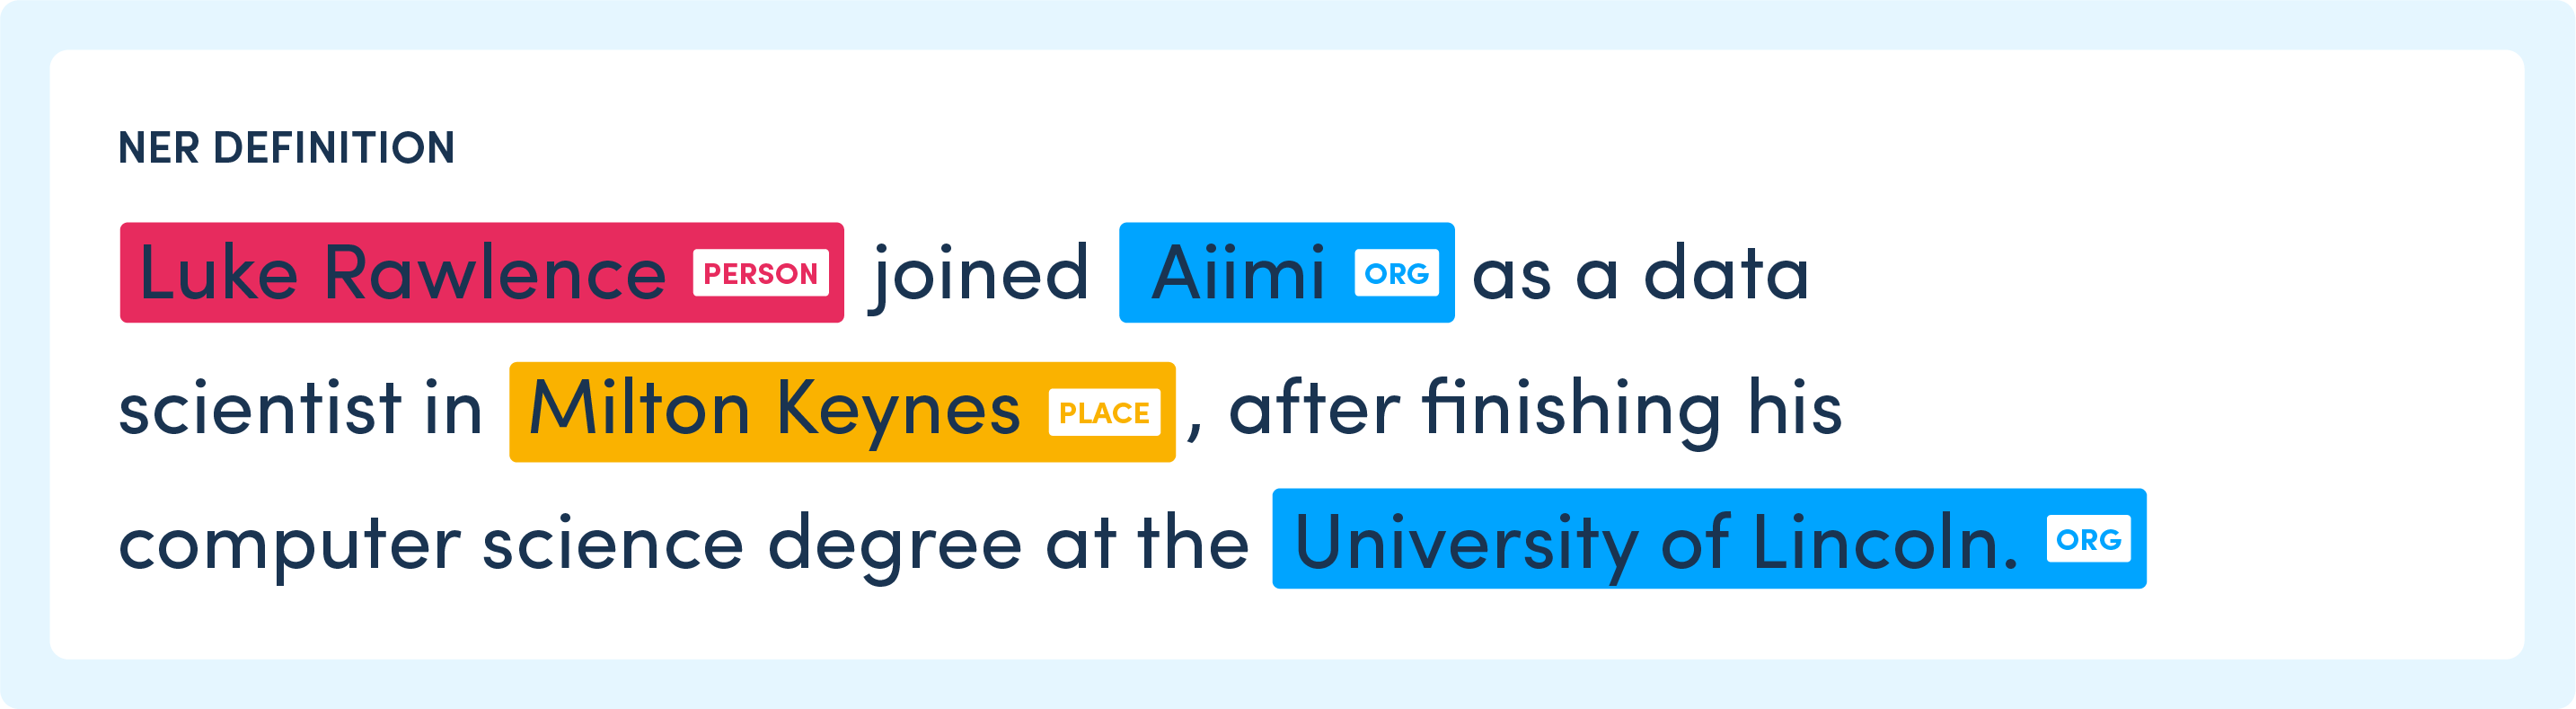

In [1]:
from IPython.display import Image
Image(filename ='/content/NER.png', width = 1000, height = 400)

# Problem Statement :

    Named Entity Recognition is a classification problem of identifying the names of people, organisations, etc. in a text corpus. The project is about Named Entity Recognition using multi-layered bidirectional LSTMs and task adapted word embeddings. Here, you will be implementing a two-layer bidirectional LSTM network using TensorFlow to classify the named entities for CoNNL 2003 NER Shared Task.

The code uses the English data from CoNLL 2003 shared task, which is present in the "data" directory of this project. We will later apply more preprocessing steps to generate tag mapping, word mapping and character  mapping. The data set contains four different types of named entities: PERSON, LOCATION, ORGANIZATION, and MISC and uses the BIO tagging scheme

BIO tagging Scheme:

    I - Word is inside a phrase of type TYPE
    B - If two phrases of the same type immediately follow each other, the first word of the second phrase will have tag B-TYPE 
    O - Word is not part of a phrase
    
Example of English-NER sentence available in the data:
    
    U.N.         NNP  I-NP  I-ORG 
    official     NN   I-NP  O 
    Ekeus        NNP  I-NP  I-PER 
    heads        VBZ  I-VP  O 
    for          IN   I-PP  O 
    Baghdad      NNP  I-NP  I-LOC 
    .            .    O     O 
    
Data Split:

    Training Data - train
    Validation Data - valid
    Testing Data - test
    

 To get started we first import the necessary libraries

# 1. Import The Dependencies

In [2]:
import nlp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from anago.utils import load_data_and_labels
from seqeval.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

from tqdm.auto import tqdm
from time import sleep

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM, 
    Dense, 
    Dropout,
    Embedding,
    Bidirectional,
    TimeDistributed
)

from tensorflow_addons.text import crf_log_likelihood, crf_decode

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either cha

# 2. Building the CRF Layer

##### CRF Layer

We have two options: 

* softmax: normalize the scores into a vector such that can be interpreted as the probability that the word belongs to class. Eventually, the probability of a sequence of tag $y$ is the product of all tags.


* linear-chain CRF: the first method makes local choices. In other words, even if we capture some information from the context thanks to the bi-LSTM, the tagging decision is still local. We don’t make use of the neighbooring tagging decisions. Given a sequence of words $w_1,…,w_m$, a sequence of score vectors $s_1,…,s_m$ and a sequence of tags $y_1,…,y_m$, a linear-chain CRF defines a global score $C \in \mathbb{R}$ such that

$$% <![CDATA[
\begin{align*}
C(y_1, \ldots, y_m) &= b[y_1] &+ \sum_{t=1}^{m} s_t [y_t] &+ \sum_{t=1}^{m-1} T[y_{t}, y_{t+1}] &+ e[y_m]\\
                    &= \text{begin} &+ \text{scores} &+ \text{transitions} &+ \text{end}
\end{align*} %]]>$$

where $T$ is a transition matrix in $R^{9×9}$ and $e,b \in R^9$ are vectors of scores that capture the cost of beginning or ending with a given tag. The use of the matrix $T$ captures linear (one step) dependencies between tagging decisions.

The motivation behind CRFs was to generate sentence level likelihoods for optimal tags. What that means is for each word we estimate maximum likelihood and then we use the Viterbi algorithm to decode the tag sequence optimally.


**Advantages of CRF over Softmax:**
* Softmax doesn't value any dependencies, this is a problem since NER the context heavily influences the tag that is assigned. This is solved by applying CRF as it takes into account the full sequence to assign the tag. 
* *Example: I-ORG cannot directly follow I-PER.*

<img src = "https://github.com/TheAnig/NER-LSTM-CNN-Pytorch/raw/master/images/crf_mode.png"></img>
<a href="https://arxiv.org/pdf/1508.01991.pdf">(Image Source)</a>

The figure shows a simple CRF network, in our case we have the inputs feeding in from our BiLSTMs, but otherwise the structure largely remains the same.

##### Evaluation schemes: Forward pass and Viterbi algorithm

Recall that the CRF computes a conditional probability. Let $y$ be a tag sequence and $x$ an input sequence of words. Then we compute

$$P(y|x) = \frac{\exp{(\text{Score}(x, y)})}{\sum_{y'} \exp{(\text{Score}(x, y')})}$$

Where the score is determined by defining some log potentials $\log \psi_i(x,y)$ such that

$$\text{Score}(x,y) = \sum_i \log \psi_i(x,y)$$

In our model, we define two kinds of potentials: emission and transition. The emission potential for the word at index $i$ comes from the hidden state of the Bi-LSTM at timestep $i$. The transition scores are stored in a $|T|x|T|$ matrix $P$, where $T$ is the tag set. In my implementation, $P_{j,k}$ is the score of transitioning to tag $j$ from tag $k$. So:

$$\text{Score}(x,y) = \sum_i \log \psi_\text{EMIT}(y_i \rightarrow x_i) + \log \psi_\text{TRANS}(y_{i-1} \rightarrow y_i)$$
$$= \sum_i h_i[y_i] + \textbf{P}_{y_i, y_{i-1}}$$

In [3]:
# Building the CRF layer class
class CRF(L.Layer):
    
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None
    
    # Building the CRF function
    def build(self, input_shape):
        
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True
    
    # This compute_mask function will compute all the mask data from the text
    def compute_mask(self, inputs, mask=None):
        
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask
    
    # This function will call the sequences in the CRF layer
    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss
    
    # This function will give the accuracy of the CRF layer
    @property
    def accuracy(self):
        
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    # With the help of this compute_output_shape will give us the shape of the output.
    def compute_output_shape(self, input_shape):
        
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)
    
    # This will give us the configuration or summary of the CRF layer.
    def get_config(self):
        
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

# 3. Building the Metrics Function

Below is the metrics function to check the classification report, precision score, recall score and f1 score.

In [4]:
# In this metrics classification report we are including both pred_tag and true_tag.
def metrics(pred_tag, true_tag):

    print(classification_report(pred_tag, true_tag))
    print('=' * 25)
    print("Precision: \t", precision_score(pred_tag, true_tag))
    print("Recall: \t", recall_score(pred_tag, true_tag))
    print("F1: \t\t", f1_score(pred_tag, true_tag))

# 4. Building the Unique Words and Tags

We now we will build unique words with tags of it, which is a list of sentences which are words along with their modified tags. Now, we want to map these individual words, tags and characters in each word, to unique numerical ID's so that each unique word, character and tag in the vocabulary is represented by a particular integer ID. To do this, we create a functions that do these mapping for us.

In [5]:
def build_uniques(arr_x, arr_y):
    
    tmp_x, tmp_y = [], []
    
    for idx in arr_x: 
        for x in idx: 
            tmp_x.append(x)
  
    for idx in arr_y: 
        for x in idx:
            tmp_y.append(x)
    return list(set(tmp_x)), list(set(tmp_y))

## Helper Functions
# In here I have text that I convert into numbers and I also have created the vocab word2idx.
def word2idx(all_words): 

    tmp = {value: idx + 2 for idx, value in enumerate(all_words)}
    tmp["UNK"] = 1 
    tmp["PAD"] = 0
    
    return tmp

# Padding the sequence to a common length
def tag2idx(all_tags):
    
    tmp = {value: idx + 1 for idx, value in enumerate(all_tags)}
    tmp["PAD"] = 0 
    
    return tmp

# This is the reverse of Word2Idx.
def idx2word(word2idx):
    
    return {idx: value for value, idx in word2idx.items()}

# This is the reverse of tag2idx.
def idx2tag(tag2idx):
    
    return {idx: value for value, idx in tag2idx.items()}

# In this function we are parsing the data.
def parser_arrays(x_train, y_train, all_words, all_tags):
    
    obj_word2idx = word2idx(all_words)
    obj_tag2idx = tag2idx(all_tags)
    
    __X = [[obj_word2idx[x] for x in value] for value in x_train] 
    __y = [[obj_tag2idx[x] for x in value] for value in y_train]

    
    X_pad = pad_sequences(maxlen=MAX_LEN, sequences=__X, padding="post", value=0)
    y_pad = pad_sequences(maxlen=MAX_LEN, sequences=__y, padding="post", value=0)
    
    return  X_pad, np.array([to_categorical(idx, num_classes=len(all_tags) + 1) for idx in y_pad])

# In this fuction we are converting the parse data into categorical.
def parser2categorical(pred, y_true, all_tags):
    
    k = tag2idx(all_tags)
    parser_idx = idx2tag(k)

    pred_tag = [[parser_idx[idx] for idx in row] for row in pred]
    y_true_tag = [[parser_idx[idx] for idx in row] for row in y_true] 
    
    return pred_tag, y_true_tag

# 5. Building the Matrix Embeddings.

A neural network with one input layer, one hidden layer, and one output layer is used to construct word embeddings. The computer is oblivious to the fact that the phrases king, prince, and man are semantically closer than queen, princess, and daughter. It only sees binary-encoded characters.

In [6]:
def build_matrix_embeddings(path, num_tokens, embedding_dim, word_index):

    hits, misses = 0, 0
    embeddings_index = {}

    print('Loading file...')

    sleep(0.5)

    for line in tqdm(open(path, encoding='utf-8')):
        word, coefs = line.split(maxsplit=1)
        embeddings_index[word] = np.fromstring(coefs, "f", sep=" ")

    print("Number %s Word Vectors." % len(embeddings_index))

    sleep(0.5)

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))

    for word, i in tqdm(word_index.items()):
        if i >= num_tokens:
            continue
        try:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                hits += 1
            else:
                embedding_vector = embeddings_index.get(str(word).lower())
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    hits += 1
                else:
                    embedding_vector = embeddings_index.get(str(word).upper())
                    if embedding_vector is not None:
                        embedding_matrix[i] = embedding_vector
                        hits += 1
                misses += 1
        except:
            embedding_matrix[i] = embeddings_index.get('UNK')

    print("Convert: %d Tokens | Periods: %d Tokens" % (hits, misses))

    return embedding_matrix

A typical deep learning model in NLP is the sequence annotation algorithm. In Python, there is also a third-party package called seqeval that may be used to evaluate the model effect of the related sequence annotation approach. BIO, IOBES Annotation mode may be used to test tasks like named entity recognition, part of speech tagging, semantic role tagging, and so forth.

In [7]:
# In here we are loading the nlp metric seqeval
ner_metric = nlp.load_metric('seqeval')

# 6. Loading the Dataset and Pre-trained vector models.

Now we are loading the train, test and validation 

In [8]:
X_train, y_train = load_data_and_labels("/content/train.txt")
X_valid, y_valid = load_data_and_labels("/content/valid.txt")
X_teste, y_teste = load_data_and_labels("/content/test.txt")

In [9]:
# Building the unique words and tags from the train, test, valid data.
all_words, all_tags = build_uniques(X_train + X_valid + X_teste, y_train)

In [10]:
MAX_LEN = max([len(x) for x in X_train + X_valid + X_teste])
NUM_WORDS = len(all_words) + 2
NUM_TAGS = len(all_tags) + 1

In [11]:
# In here we are parsing the train, test and validation data.
X_TRAIN, Y_TRAIN = parser_arrays(X_train, y_train, all_words, all_tags)
X_VALID, Y_VALID = parser_arrays(X_valid, y_valid, all_words, all_tags)
X_TESTE, Y_TESTE = parser_arrays(X_teste, y_teste, all_words, all_tags)

In [12]:
# In here we will use pretrained models to train our NER model and to give better result.
word_indexes = word2idx(all_words)
# glove.840B.300d.txt contains vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.
PATH_GLOVE = '/content/glove.840B.300d.txt' 
# This FastText English word vectors released by Facebook. Each line contains a word followed by its vectors, like in the default fastText text format. Each value is space separated. Words are ordered by descending frequency.
PATH_FASTTET = '/content/crawl-300d-2M.vec'

word_weights = \
np.concatenate([build_matrix_embeddings(PATH_GLOVE, NUM_WORDS, 300, word_indexes),
                build_matrix_embeddings(PATH_FASTTET, NUM_WORDS, 300, word_indexes)], axis=1)

Loading file...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  from ipykernel import kernelapp as app



Encontrado 2195884 Word Vectors.



Convertidos: 26949 Tokens | Perdidos: 3440 Tokens
Loading file...



Encontrado 1999996 Word Vectors.



Convertidos: 26560 Tokens | Perdidos: 3893 Tokens


# 7. Building and Training the Bi-LSTM model.

In [13]:
# Building the model layers with Bi-LSTM.
model = Sequential()
model.add(Embedding(input_dim=word_weights.shape[0],
                    output_dim=word_weights.shape[1],
                    input_length=MAX_LEN,
                    weights=[word_weights],
                    trainable=False,
                    mask_zero=False))

model.add(Bidirectional(LSTM(units=256, 
                             return_sequences=True, 
                             recurrent_dropout=0.1)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Dense(units=512, 
                                activation='relu')))
model.add(TimeDistributed(Dense(units=NUM_TAGS, 
                                activation='relu')))

crf = CRF(NUM_TAGS, sparse_target=True)
model.add(crf)
model.compile(optimizer=optimizers.Adam(lr=0.001), 
              loss=crf.loss, 
              metrics=[crf.accuracy])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 124, 600)          18174600  
_________________________________________________________________
bidirectional (Bidirectional (None, 124, 512)          1755136   
_________________________________________________________________
time_distributed (TimeDistri (None, 124, 512)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 124, 512)          262656    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 124, 10)           5130      
_________________________________________________________________
crf (CRF)                    (None, 124, 10)           100       
Total params: 20,197,622
Trainable params: 2,023,022
Non-trainable params: 18,174,600
____________________________________

In [15]:
z = idx2tag(tag2idx(all_tags))

In [16]:
History = model.fit(X_TRAIN,
                    Y_TRAIN,
                    batch_size=256,
                    epochs=15,
                    validation_data=[X_VALID, Y_VALID],  
                    verbose=1)

Epoch 1/15
55/55 [==============================] - 61s 1s/step - loss: 17.4437 - viterbi_accuracy: 0.9577 - val_loss: 0.0000e+00 - val_viterbi_accuracy: 0.0000e+00
Epoch 2/15
55/55 [==============================] - 60s 1s/step - loss: 6.3376 - viterbi_accuracy: 0.9848 - val_loss: 0.0000e+00 - val_viterbi_accuracy: 0.0000e+00
Epoch 3/15
55/55 [==============================] - 60s 1s/step - loss: 4.3608 - viterbi_accuracy: 0.9897 - val_loss: 0.0000e+00 - val_viterbi_accuracy: 0.0000e+00
Epoch 4/15
55/55 [==============================] - 59s 1s/step - loss: 3.3674 - viterbi_accuracy: 0.9916 - val_loss: 0.0000e+00 - val_viterbi_accuracy: 0.0000e+00
Epoch 5/15
55/55 [==============================] - 59s 1s/step - loss: 2.6339 - viterbi_accuracy: 0.9930 - val_loss: 0.0000e+00 - val_viterbi_accuracy: 0.0000e+00
Epoch 6/15
55/55 [==============================] - 59s 1s/step - loss: 2.2170 - viterbi_accuracy: 0.9937 - val_loss: 0.0000e+00 - val_viterbi_accuracy: 0.0000e+00
Epoch 7/15
55/5

In [17]:
model.evaluate(X_TESTE, Y_TESTE, verbose=1, batch_size=512)

7/7 [==============================] - 2s 300ms/step - loss: 187.0600 - viterbi_accuracy: 0.9932


[187.0599822998047, 0.9932421445846558]

In [ ]:
from pickle import dump,load
# save the model to file
model.save('/content/epochNER.h5')

# 8. Predictions and Evaluation.

In [18]:
preds, y_true = np.argmax(model.predict(X_TESTE, verbose=1, batch_size=256), axis=-1), np.argmax(Y_TESTE, -1)

14/14 [==============================] - 2s 154ms/step


In [19]:
pred_tag, true_tag = parser2categorical(preds, y_true, all_tags) 
metrics(pred_tag, true_tag)

           precision    recall  f1-score   support

      ORG       0.85      0.81      0.83      1742
      PAD       1.00      1.00      1.00      3452
      LOC       0.91      0.85      0.88      1782
     MISC       0.74      0.70      0.72       740
      PER       0.89      0.86      0.87      1671

micro avg       0.92      0.89      0.90      9387
macro avg       0.92      0.89      0.90      9387

Precision: 	 0.916923076923077
Recall: 	 0.8888888888888888
F1: 		 0.9026883756152972


In [20]:
# Checking all the evaluation metrics of the each words which got tagged.
ner_metric.compute(pred_tag, true_tag)

{'ORG': {'precision': 0.8128587830080367,
  'recall': 0.8524984948826009,
  'f1': 0.8322068762856303,
  'number': 1661},
 'AD': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 3452},
 'LOC': {'precision': 0.8540965207631874,
  'recall': 0.9124700239808153,
  'f1': 0.8823188405797101,
  'number': 1668},
 'PER': {'precision': 0.8593656493117894,
  'recall': 0.8880643166357453,
  'f1': 0.8734793187347931,
  'number': 1617},
 'MISC': {'precision': 0.7,
  'recall': 0.7378917378917379,
  'f1': 0.7184466019417476,
  'number': 702},
 'overall_precision': 0.8888888888888888,
 'overall_recall': 0.916923076923077,
 'overall_f1': 0.9026883756152972,
 'overall_accuracy': 0.9969498239025438}

In [21]:
index = 67

print("{:15}   {:5}:   [{}]".format("Word", "True", "Pred"))
print("=" * 35)

k = tag2idx(all_words)
word_parser_idx = idx2tag(k)

for word, true, pred in zip([word_parser_idx[x] for x in X_TESTE[index]], 
                            true_tag[index], 
                            pred_tag[index]):

    if pred != 'PAD':
        print("{:15}   {:5}    [{}]".format(word, true, pred))

Word              True :   [Pred]
3024.95           O        [O]
461               B-PER    [B-PER]
950               I-PER    [I-PER]
Comisetti         O        [O]
characteristically   B-LOC    [B-LOC]
couterpart        O        [O]
.492              O        [O]


So, our model is performing better with an accuracy of 90% to 95% and perfectly tagging the entity with IOB.